# **Model-specific explainability techniques**


It is important to understand the decision-making processes behind ML algorithms, especially for high-risk applications. We will see here how to apply model-specific explainability techniques in a binary classification context. Let's imagine that a bank is trying to decide whether to give a mortgage to applicants. They use a machine learning algorithm to select viable candidates. The candidates are assigned either 0 if they are declined the mortgage or 1 if the mortgage is originated. 


In this notebook, we will:
1. Load and organise the data 
2. Train the decision tree
3. Global explanations
4. Local explanations 

We will implement the decision tree in [scikit-learn](https://scikit-learn.org/stable/). 


## **Install Libraries and load data**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

First, we load data from out host website using pandas.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/code_club/master/mortgage_data_balanced.csv")

 Then, we explore and reorganize the features. 

In [ ]:
keep_vars = ['respondent_id', 'as_of_year', 'agency_abbr', 'loan_type_name', 'loan_amount_000s', 'owner_occupancy_name',
             'loan_purpose_name', 'property_type_name', 'preapproval_name', 'msamd_name', 'state_abbr', 'county_name',
             'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1', 'co_applicant_race_name_1',
             'applicant_sex_name', 'co_applicant_sex_name', 'applicant_income_000s', 'purchaser_type_name', 
             'denial_reason_name_1', 'hoepa_status_name', 'lien_status_name', 'population', 'minority_population',
             'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
             'number_of_1_to_4_family_units', 'action_taken_name']

df = df[keep_vars].copy()

In [ ]:
# categorical variables
cat_variables = cat_variables = ['applicant_ethnicity_name', 'applicant_race_name_1', 'applicant_sex_name', 'agency_abbr',
                                 'owner_occupancy_name', 'property_type_name', 'loan_purpose_name', 'loan_type_name']

# other integer variables
int_variables = ['loan_amount_000s', 'applicant_income_000s', 'population', 'minority_population', 
                 'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
                 'number_of_1_to_4_family_units']

# target variable
output_variable = ['action_taken_name']

We need to preprocess the categorical variables and change them to one-hot encoding

In [ ]:
### Pre-processing
from sklearn.preprocessing import OneHotEncoder
# Mapping categorical variables to one-hot encoding
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# consolidating a final dataset
X = pd.concat([df[int_variables], df_cat], axis=1)
y = (df[output_variable] == "Loan originated").copy()

Note that the features include some protected attributes. Since we do not want the algorithm to make the decision based on these protected attributes, we proceed to remove these features from the dataset. 

In [ ]:
# removing race, ethnicity, sex and minority population from X
X_ub = X[[
    'loan_amount_000s', 'applicant_income_000s', 'population', 'hud_median_family_income', 'tract_to_msamd_income', 
    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'property_type_name_Manufactured housing',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed'
]].copy()

# protected attributtes
X_groups = X[[
    'minority_population', 'applicant_ethnicity_name_Hispanic or Latino',
       'applicant_ethnicity_name_Not Hispanic or Latino',
       'applicant_race_name_1_American Indian or Alaska Native',
       'applicant_race_name_1_Asian',
       'applicant_race_name_1_Black or African American',
       'applicant_race_name_1_Native Hawaiian or Other Pacific Islander',
       'applicant_race_name_1_White', 'applicant_sex_name_Female',
       'applicant_sex_name_Male'
]].copy()


Finally, we want to observe the data and some of its statistics. 

In [ ]:
X.describe()

,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,applicant_ethnicity_name_Hispanic or Latino,applicant_ethnicity_name_Not Hispanic or Latino,...,owner_occupancy_name_Owner-occupied as a principal dwelling,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,188.47100,100.106400,5739.743600,21.953384,69228.460000,115.593274,1601.492800,2063.751600,0.066600,0.933400,...,0.890800,0.030800,0.969200,0.07520,0.289200,0.63560,0.806200,0.146000,0.014800,0.033000
std,164.32887,112.223575,2936.536592,22.271644,14070.949447,37.167028,906.289128,1113.332253,0.249353,0.249353,...,0.311921,0.172793,0.172793,0.26374,0.453436,0.48131,0.395314,0.353142,0.120764,0.178654
min,1.00000,1.000000,500.000000,0.600000,16300.000000,23.190001,19.000000,43.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,86.00000,45.000000,3788.750000,6.350000,60000.000000,91.677500,1021.000000,1346.750000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
50%,149.00000,73.000000,5197.500000,13.780000,66600.000000,109.535000,1443.000000,1847.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.00000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000
75%,247.00000,119.000000,6955.000000,29.170000,76700.000000,132.440002,1967.750000,2484.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000
max,2500.00000,2000.000000,34055.000000,99.809998,111900.000000,390.839996,9880.000000,10724.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


## **Train decision tree**


Model-specific explainability consists of using an interpretable model for training. We choose to use a decision-tree implemented in [sklearn] (https://scikit-learn.org/stable/modules/tree.html#tree). We fit the model using 10-fold cross validation, and then display the results across a range of metrics. 

In [ ]:
# fit and cross-validate model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

## classification tree
model = DecisionTreeClassifier(max_depth=2, criterion="gini", class_weight="balanced")

## performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               } # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## 10-fold cv
k_folds = StratifiedKFold(n_splits=10, random_state=10, shuffle=True) # https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
df_metrics = pd.DataFrame(index=range(10), columns=perf_metrics.keys())

# main loop
k = 0
for (train, test) in k_folds.split(X_ub, y):
    # fit model
    model.fit(X_ub.values[train], y.values[train])
       
    # test model
    ypred_class = model.predict(X_ub.values[test])
    ypred_prob = model.predict_proba(X_ub.values[test])[:, 1]

    # compute performance metrics
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_prob)
        else:
            df_metrics.loc[k, pf] = perf_metrics[pf](y.values[test], ypred_class)
    k += 1

In [ ]:
df_metrics

,Accuracy,Precision,Recall,AUC,F1-Score,Brier
0,0.602,0.70229,0.365079,0.651194,0.480418,0.230183
1,0.608,0.71875,0.365079,0.66097,0.484211,0.228347
2,0.566,0.635659,0.325397,0.615463,0.430446,0.240093
3,0.596,0.582492,0.689243,0.642122,0.631387,0.232941
4,0.588,0.657343,0.374502,0.62281,0.477157,0.238476
5,0.578,0.572464,0.629482,0.630794,0.59962,0.234111
6,0.542,0.541985,0.565737,0.580457,0.553606,0.243732
7,0.59,0.580986,0.657371,0.63377,0.616822,0.232712
8,0.558,0.627119,0.294821,0.601666,0.401084,0.240723
9,0.6,0.691729,0.366534,0.649698,0.479167,0.231897


In [ ]:
df_metrics.mean()

Accuracy     0.582800
Precision    0.631082
Recall       0.463324
AUC          0.628895
F1-Score     0.515392
Brier        0.235321
dtype: float64

## **Global Explanations**

In order to have a complete picture of the tree, we can export it using [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html). We can then retrieve the output text file from http://webgraphviz.com/. If you open the file you will see that it contains the whole structure of the tree,  providing a clear gobal view. 

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(model, out_file="class_tree.dot", feature_names=X_ub.columns, 
                class_names = ["Denied", "Originated"], rounded = True) 
# you have to go to http://webgraphviz.com/ and get the file class_tree.dot 

If we open the text file, we can see that the root node immediately subdivides the data into "applicant_income_000s"<= 63.5 or "applicant_income_000s"> 63.5. We can therefore look at the data for which the income is lower than the threshold, and see if the data is differently distributed across classes, i.e. observing how income is related to mortgage outcome for all individuals with an income below the threshold.

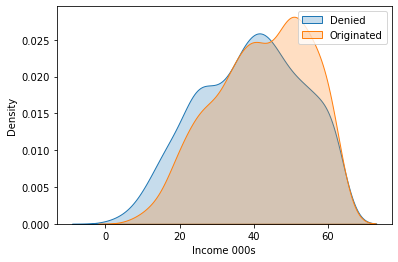

In [ ]:
denied_income = X.loc[((y.values == 0) & 
                            (X["applicant_income_000s"].values.reshape(-1, 1) <= 63.5)).reshape(1, -1)[0], 
                           'applicant_income_000s']
originated_income = X.loc[((y.values == 1) & 
                          (X["applicant_income_000s"].values.reshape(-1, 1) <= 63.5)).reshape(1, -1)[0], 
                         'applicant_income_000s']
ax = sns.kdeplot(denied_income, shade=True, label="Denied")
ax = sns.kdeplot(originated_income, shade=True,  label="Originated")
ax.set_xlabel("Income 000s")
plt.legend()

The group with originated mortgage seems to have more individuals with  relatively higher income. 

## **Local Explanations**

We now want to explan the process that determines how an individual instance is assigned a certain outcome. In order to do this, we need to recreate the whole path of the data point through the tree. We do this using the function below

In [ ]:
def tree_local_explanation(model, input_X, sample_id, labels_y=None):

    # The decision estimator has an attribute called tree_  which stores the entire
    # tree structure and allows access to low level attributes. The binary tree
    # tree_ is represented as a number of parallel arrays. The i-th element of each
    # array holds information about the node `i`. Node 0 is the tree's root. NOTE:
    # Some of the arrays only apply to either leaves or split nodes, resp. In this
    # case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node

    #n_nodes = # The decision estimator has an attribute called tree_  which stores the entire
    # tree structure and allows access to low level attributes. The binary tree
    # tree_ is represented as a number of parallel arrays. The i-th element of each
    # array holds information about the node `i`. Node 0 is the tree's root. NOTE:
    # Some of the arrays only apply to either leaves or split nodes, resp. In this
    # case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node

    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    # First let's retrieve the decision path of each sample. The decision_path
    # method allows to retrieve the node indicator functions. A non zero element of
    # indicator matrix at the position (i, j) indicates that the sample i goes
    # through the node j.

    node_indicator = model.decision_path(input_X)

    # Similarly, we can also have the leaves ids reached by each sample.

    leave_id = model.apply(input_X)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    # HERE IS WHAT YOU WANT
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:

        if leave_id[sample_id] == node_id:  # <-- changed != to ==
            #continue # <-- comment out
            y_pred = (model.predict(X_ub.iloc[sample_id].values.reshape(1, -1)))
            print("\n terminal/leaf node %s reached, decision is %s" % (leave_id[sample_id], 
                                                                    labels_y[int(y_pred)]) ) # <--

        else: # < -- added else to iterate through decision nodes
            if (input_X.iloc[sample_id][feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            print("\n decision node %s, individual %s has (%s = %s %s %s), goes to"
                  % (node_id,
                     sample_id,
                     X_ub.columns[feature[node_id]],
                     input_X.iloc[sample_id][feature[node_id]], # <-- changed i to sample_id
                     threshold_sign,
                     threshold[node_id]))
    print()


In [ ]:
tree_local_explanation(model, X_ub, 0, labels_y=["Loan rejected", "Loan originated"])

Rules used to predict sample 0: 

 decision node 0, individual 0 has (applicant_income_000s = 38.0 <= 63.5), goes to

 decision node 1, individual 0 has (loan_amount_000s = 99.0 > 38.5), goes to

 terminal/leaf node 3 reached, decision is Loan rejected



We can see that teh data point 0 is rejected by the algorithm because the applicant has an income lower than the threshold, and is asking for a loan higher than the threshold. 